# Fake Review Detector

## Project Statement

- Fake reviews are artificially generated reviews meant to manipulate consumer perception. They can be positive (boosting sales) or negative (damaging competitors). This project aims to develop an machine learning model to detect fake reviews, distinguishing them from genuine ones.

- My goals include:
    - Detect fake reviews with high accuracy using NLP techniques.
    - Compare traditional models (logistic regression, random forest) vs. NLP approaches (LSTM, BERT).
    - Explore unsupervised learning techniques to find hidden patterns in review text.
    - Provide insights on fake review characteristics (e.g., linguistic features, sentiment).

## Data Source

Salminen, J., Kandpal, C., Kamel, A. M., Jung, S., & Jansen, B. J. (2022). Creating and detecting fake reviews of online products. Journal of Retailing and Consumer Services, 64, 102771. https://doi.org/10.1016/j.jretconser.2021.102771

The generated fake reviews dataset, containing 20k fake reviews and 20k real product reviews. OR = Original reviews (presumably human created and authentic); CG = Computer-generated fake reviews.

## Data Prep

### Load the data

In [31]:
import pandas as pd
df = pd.read_csv("/Users/lauriezeng/Downloads/fake reviews dataset.csv")

### Check the dataset

In [32]:
print(df.head())  # Show first 5 rows

             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...  


In [33]:
print(df.columns)

Index(['category', 'rating', 'label', 'text_'], dtype='object')


In [34]:
print(df.isnull().sum())  # Count missing values in each column

category    0
rating      0
label       0
text_       0
dtype: int64


There is no missing values in the dataset.

## EDA

### Data Overview

In [35]:
num_entries = df.shape[0]
print(f"Number of data entries: {num_entries}")

Number of data entries: 40432


label
1    20216
0    20216
Name: count, dtype: int64


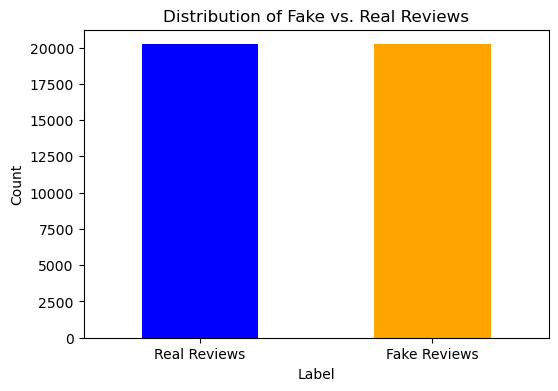

In [36]:
# Check if the dataset is balanced

# Ensure the label column is populated
if df["label"].isnull().all():
	df["label"] = df["label"].fillna("CG")  # Assuming all labels are "CG" for this example

# map these labels to binary values (Fake = 1, Real = 0).
df["label"] = df["label"].map({"CG": 1, "OR": 0})
label_counts = df["label"].value_counts()
print(label_counts)

# Plot the distribution of labels
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Fake vs. Real Reviews")
plt.xticks(ticks=[0, 1], labels=["Real Reviews", "Fake Reviews"], rotation=0)
plt.show()

The dataset has 40432 entries, and it is well balanced.

### Review Length Analysis

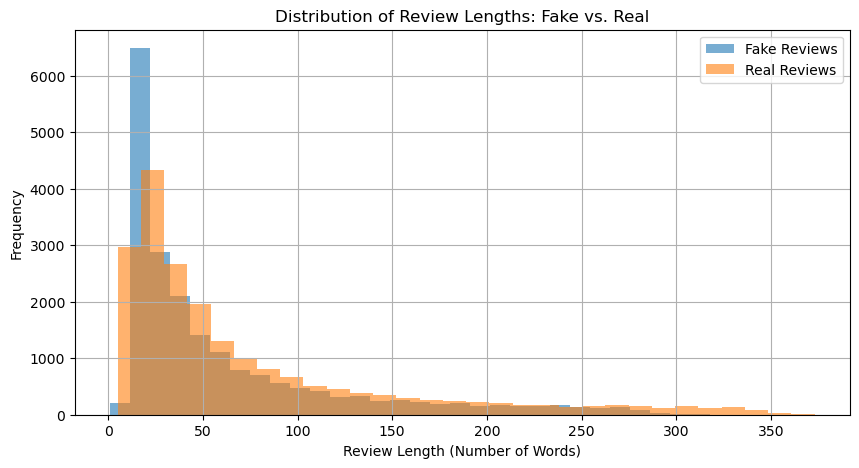

In [37]:
import matplotlib.pyplot as plt

df["review_length"] = df["text_"].apply(lambda x: len(str(x).split()))

# Plot distribution of review lengths
plt.figure(figsize=(10, 5))
df[df["label"] == 1]["review_length"].hist(alpha=0.6, label="Fake Reviews", bins=30)
df[df["label"] == 0]["review_length"].hist(alpha=0.6, label="Real Reviews", bins=30)
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Review Lengths: Fake vs. Real")
plt.show()

- Fake reviews are likely shorter and less detailed than real reviews.
- Real reviews show greater variability, indicating more natural writing patterns.
- Short review length might be a useful feature for detecting fake reviews.

### Most Common Words in Fake vs. Real Reviews


In [38]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))


def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Remove punctuation & special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenization
    words = word_tokenize(text)
    # Remove stopwords & lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)


# Apply preprocessing
df["cleaned_text"] = df["text_"].apply(clean_text)

# Check cleaned reviews
print(df["cleaned_text"].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lauriezeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lauriezeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lauriezeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    love well made sturdy comfortable love itvery ...
1     love great upgrade original ive mine couple year
2              pillow saved back love look feel pillow
3          missing information use great product price
4                  nice set good quality set two month
Name: cleaned_text, dtype: object


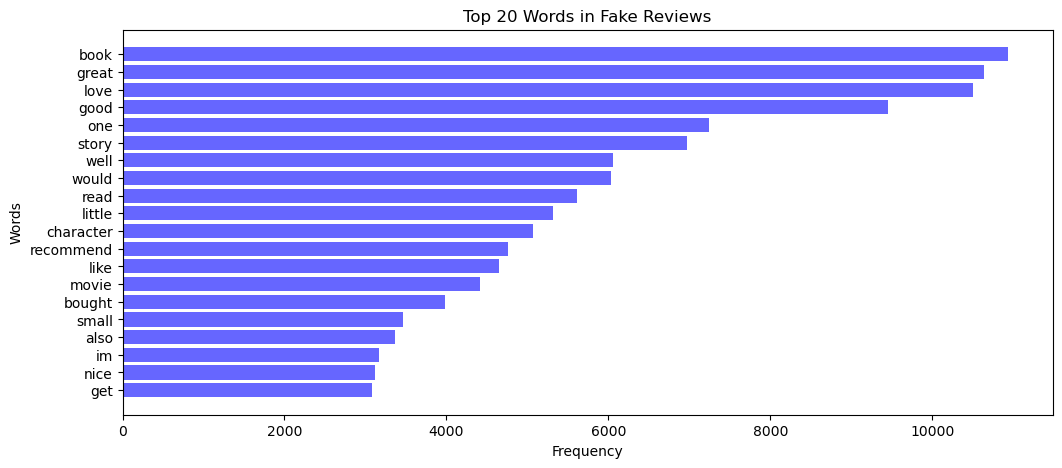

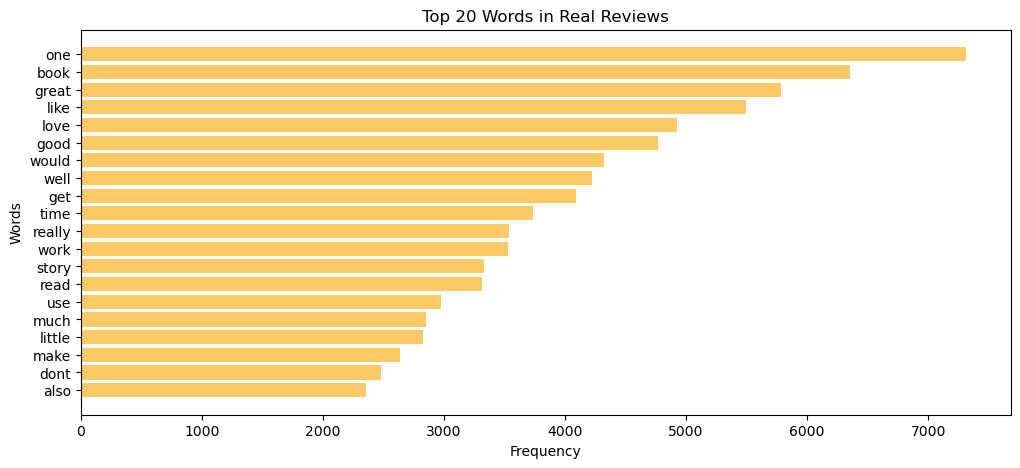

In [39]:
from collections import Counter
import matplotlib.pyplot as plt

# Function to get top words
def get_top_words(texts, n=20):
    all_words = " ".join(texts).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get top words for each category
fake_top_words = get_top_words(df[df["label"] == 1]["cleaned_text"], n=20)
real_top_words = get_top_words(df[df["label"] == 0]["cleaned_text"], n=20)

# Convert to dictionary for plotting
fake_words, fake_counts = zip(*fake_top_words)
real_words, real_counts = zip(*real_top_words)

# Plot Fake Reviews Word Frequency
plt.figure(figsize=(12,5))
plt.barh(fake_words[::-1], fake_counts[::-1], color="blue", alpha=0.6)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Words in Fake Reviews")
plt.show()

# Plot Real Reviews Word Frequency
plt.figure(figsize=(12,5))
plt.barh(real_words[::-1], real_counts[::-1], color="orange", alpha=0.6)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Words in Real Reviews")
plt.show()


The high frequency words in both classes are very simmilar. This tells that common words may not be a significant factor for classfication. 

### Sentiment Analysis

Note: you may need to restart the kernel to use updated packages.


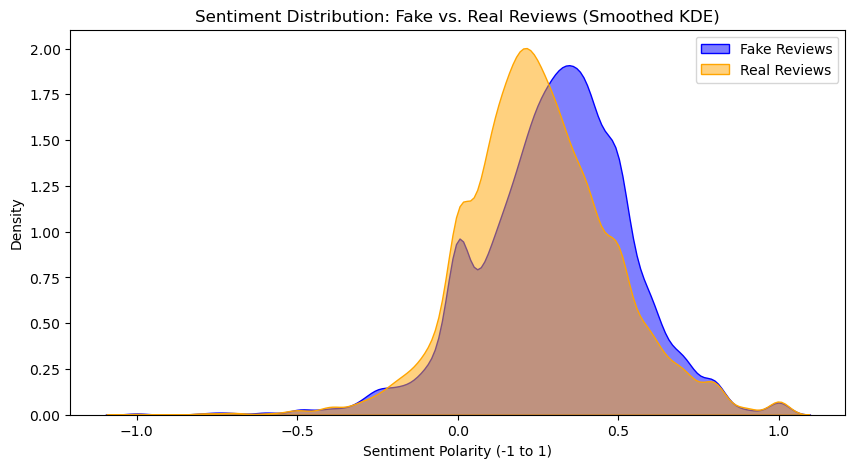

In [40]:
%pip install textblob

from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt


# Function to calculate sentiment polarity (-1 to 1)
df["sentiment"] = df["cleaned_text"].apply(lambda x: TextBlob(x).sentiment.polarity)


plt.figure(figsize=(10,5))

# KDE plot for Fake Reviews
sns.kdeplot(df[df["label"] == 1]["sentiment"], fill=True, color="blue", alpha=0.5, label="Fake Reviews")

# KDE plot for Real Reviews
sns.kdeplot(df[df["label"] == 0]["sentiment"], fill=True, color="orange", alpha=0.5, label="Real Reviews")

plt.xlabel("Sentiment Polarity (-1 to 1)")
plt.ylabel("Density")
plt.title("Sentiment Distribution: Fake vs. Real Reviews (Smoothed KDE)")
plt.legend()
plt.show()


- Fake reviews (blue) tend to have slightly higher sentiment scores than real reviews. This suggests that fake reviews may lean towards more positive sentiment, potentially due to exaggerated praise.
- Both distributions peak around 0.25, meaning most reviews have a slightly positive sentiment.
- Both fake and real reviews have very few strongly negative reviews.

###  Rating vs. Fake/Real Reviews
Do fake reviews tend to have higher or lower ratings?

/var/folders/qr/19v993z57q535jfw7xggwbc00000gn/T/ipykernel_72756/921393533.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["label"], y=df["rating"], palette=["orange", "blue"])


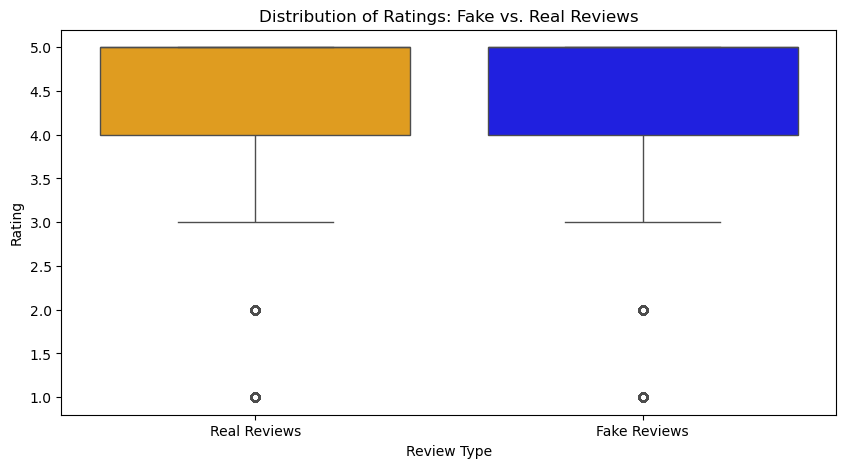

In [41]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.boxplot(x=df["label"], y=df["rating"], palette=["orange", "blue"])
plt.xticks([0,1], ["Real Reviews", "Fake Reviews"])
plt.xlabel("Review Type")
plt.ylabel("Rating")
plt.title("Distribution of Ratings: Fake vs. Real Reviews")
plt.show()


In this dataset, the ratings distribution for fake and real reviews looks nearly identical

### TF-IDF

- Reducing the impact of common words (e.g., "the", "and") that appear in both categories.
- Highlighting unique terms that are overused in fake reviews (e.g., "best ever", "highly recommend").
- Providing numerical features that machine learning models can use for classification.


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 words to reduce dimensionality
    stop_words="english",  # Remove common stopwords
    ngram_range=(1, 2),  # Use unigrams and bigrams for better context capture
)

# Fit and transform the cleaned text
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_text"])

# Convert to DataFrame for better visualization
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# Check shape and sample features
print("TF-IDF Matrix Shape:", X_tfidf.shape)
print(tfidf_df.head())

TF-IDF Matrix Shape: (40432, 5000)
    aa  ability  able  able read  able use  abrupt  absolute  absolutely  \
0  0.0      0.0   0.0        0.0       0.0     0.0       0.0         0.0   
1  0.0      0.0   0.0        0.0       0.0     0.0       0.0         0.0   
2  0.0      0.0   0.0        0.0       0.0     0.0       0.0         0.0   
3  0.0      0.0   0.0        0.0       0.0     0.0       0.0         0.0   
4  0.0      0.0   0.0        0.0       0.0     0.0       0.0         0.0   

   absolutely love  absolutely loved  ...  youre looking  youtube  youve   yr  \
0              0.0               0.0  ...            0.0      0.0    0.0  0.0   
1              0.0               0.0  ...            0.0      0.0    0.0  0.0   
2              0.0               0.0  ...            0.0      0.0    0.0  0.0   
3              0.0               0.0  ...            0.0      0.0    0.0  0.0   
4              0.0               0.0  ...            0.0      0.0    0.0  0.0   

   yr old  zero  zip 

## Model Training

### Data Split

In [43]:
from sklearn.model_selection import train_test_split

# Define features (TF-IDF matrix) and labels (real=0, fake=1)
X = X_tfidf  # TF-IDF features
y = df["label"]  # Binary labels

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Training Set: (32345, 5000), Testing Set: (8087, 5000)


### Supervised Learning Models


- Logistic Regression (Baseline model)
- Random Forest
- Support Vector Machine (SVM)
- Gradient Boosting (XGBoost)

In [46]:
%pip install xgboost

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


Note: you may need to restart the kernel to use updated packages.


In [47]:

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel="linear"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Make predictions

    # Calculate evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary"
    )

    # Store results
    results[name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
    }

results_df = pd.DataFrame(results).T


/Users/lauriezeng/opt/anaconda3/envs/ml2_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:23:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Display results
# Display results
print(results_df)


                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.881538   0.885529  0.876329  0.880905
Random Forest        0.844813   0.847458  0.840960  0.844196
SVM                  0.884630   0.889724  0.878061  0.883854
XGBoost              0.831582   0.859866  0.792233  0.824665


- SVM is the best performing model and should be the primary choice.
- Logistic Regression is a close second and is computationally efficient.
- Random Forest and XGBoost are weaker for this dataset, possibly due to text feature sparsity.

